# TSL PDF Scraper

Scraper for extractng results and timing data from TSL results documents.


Part of a set of tools that will:

- automate the detection and selection of scrapers from the timing sheet document type;
- save *pandas* dataframe versions of the data as (unindexed) CSV files;
- automate the generation of file names and save dataframes from the document type;
- automate the scrapes to take a timing results booklet PDF and save one or more tables using CSV format for each document it contains.


This initial scraper is based primarily on Britcar timing sheets, although examples are also given around some BTCC timing sheets.

Hopefully, the timing sheets are consistent. If not, this scraper will be nothing more than a bespoke curiousity, although it may provide colues to a more robust scraper.

If nothing else, this should work as a walkthrough of how to scrape tables from a variety of PDF documents.

Where possible, data will be scraped into database tables that use a similar structure to the tables used in the `ergast` motor racing database.

The Python Tabula wrapper doesn't appear to work for me... so this notebook will use the *R* `tabulizr` package.

## TSL Timing Sheets

TSL publish (and archive) a range of timing sheet documents for the race series they provide timing services for.

A range of sheets are bundled in a "PDF book" for each race series. The scraper described here is designed to scrape data from the sheets contained within a PDF book into a simple SQLite database.

The range of timing sheets published by TSL for an event may include some or all of the following sheets for practice, qualifying and race:

- CLASSIFICATION
- 2ND FASTEST CLASSIFICATION
- SECTOR ANALYSIS
- BEST SPEEDS
- BEST SECTORS
- WEATHER CONDITIONS
- STATISTICS
- GRID
- LAP CHART
- POSITION CHART

## Making a Start

The `tabulizer` package provides an R wrapper around the [tabulapdf/tabula-java](https://github.com/tabulapdf/tabula-java) service that underpins the browser based [*Tabula*](https://tabula.technology/) PDF table scraping application.

In [ ]:
#install.packages("tabulizer")

In [1]:
#sudo R CMD javareconf
library("tabulizer")

In [2]:
PDF <- "2019/191403cli.pdf"

In [3]:
get_page_dims(PDF, pages=1)

[[1]]
[1] 595.2199 842.0000

In [4]:
#locate_areas("2019/191403cli.pdf", pages=1)

## Extract Page Info

We can extract document metadata from the PDFs using the `extract_metadata()` function:

In [5]:
extract_metadata(PDF)

$pages
[1] 34

$title
[1] "CLIO Grid"

$author
[1] "Office-Web"

$subject
NULL

$keywords
NULL

$creator
[1] "PScript5.dll Version 5.2.2"

$producer
[1] "Acrobat Distiller 9.0.0 (Windows)"

$created
[1] "Mon Apr 20 18:33:41 BST 2009"

$modified
[1] "Sat Apr 06 17:28:07 BST 2019"

$trapped
NULL

We can also extract text from a page using the `extract_text()` function:

In [6]:
t <- extract_text(PDF, page=1)

#Split the separate lines into a list
strsplit( t , '\n')[[1]]

[1] "2019 RENAULT UK CLIO CUP "                
[2] "CHAMPIONSHIP "                            
[3] "Rounds 1 & 2 "                            
[4] "Brands Hatch Indy"                        
[5] "6th & 7th April 2019"                     
[6] "Results Provided by Timing Solutions Ltd "
[7] "www.tsl-timing.com"

In [7]:
series <- strsplit( t , '\n')[[1]][1]
series

[1] "2019 RENAULT UK CLIO CUP "

Let's try another one...

In [8]:
extract_text('results/Dunlop Endurance Championship.pdf', page=1)

[1] "    \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nResults Provided by Timing Solutions Ltd \nwww.tsl-timing.com \n \n  \n \nBRITCAR ENDURANCE \nCHAMPIONSHIP \n \nSilverstone International Circuit \n     30th March 2019 \n"

Okay, so maybe we need to do a bit more cleaning...

Let's work on the assumption that the first none copyright related notice is the series...

In [22]:
#install.packages("rlist")

library(rlist)
library(magrittr)

#library(stringi)

library(stringr)

#Clean whitespace
#THe list.map function applies the split to each item in the list
items <- list.map( strsplit( extract_text('results/Dunlop Endurance Championship.pdf', page=1)[[1]], '\n') , trimws(.) )

#Remove empty list items
items <- list.map( items , stri_remove_empty(.) )[[1]]

#Remove the TSL boilerplate items
items[! items %in% c('Results Provided by Timing Solutions Ltd', 'www.tsl-timing.com')]


Warning message:
“package ‘stringr’ was built under R version 3.5.2”

[1] "BRITCAR ENDURANCE"                 "CHAMPIONSHIP"                     
[3] "Silverstone International Circuit" "30th March 2019"

In [23]:
get_TSL_series <- function(PDF){
    t <- extract_text(PDF, page=1)
    
    items <- list.map( strsplit( t[[1]], '\n') , trimws(.) )

    items <- list.map( items , stri_remove_empty(.) )[[1]]

    items <- items[! items %in% c('Results Provided by Timing Solutions Ltd', 'www.tsl-timing.com')]

    items[1]
}

get_TSL_series(PDF)


[1] "2019 RENAULT UK CLIO CUP"

Let's start to think about how we might manage the data. Use data frames for now, but with a view to casting dataframes as SQLite tables.

In [24]:
series_df <- data.frame(series, PDF )
series_df

series,PDF
2019 RENAULT UK CLIO CUP,2019/191403cli.pdf


In [25]:
library(DBI)

db <- dbConnect(RSQLite::SQLite(), "testdb.sqlite")

In [27]:
#dbRemoveTable(db, "series")
dbWriteTable(db, "series", series_df) #append=
dbGetQuery(db, 'SELECT * FROM series LIMIT 5')

series,PDF
2019 RENAULT UK CLIO CUP,2019/191403cli.pdf


We can use the `area=` parameter to specify `(top, left, bottom, right)` area co-ordinates within which `tabulizer` should look for the table information.

For example, the page footer may contain useful information, such as the session time, weather and track condition.

In [28]:
#Page footer
t = extract_text("2019/191403cli.pdf", pages = 9, area = list(c(760, 0, 1000, 600)))
cat(t)

Results can be found at www.tsl-timing.com Page 5 of 6 Printed - 11:57 Saturday, 06 April 2019
Weather / Track : Cloudy / Dry
Start: 11:24  Flag 11:54  End: 11:55
Circuit Length = 1.2079 miles
Brands Hatch Indy


How about the page header?

In [29]:
#Page header
t = extract_text(PDF, pages = 13, area = list(c(0, 0, 120, 600)))
cat(t)

2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - WEATHER CONDITIONS


Where the header is split over two lines, we can can split the string to access the separate components:

In [30]:
paste(strsplit(t, '\n')[[1]][1], '*and*', strsplit(t, '\n')[[1]][2])

[1] "2019 Renault UK Clio Cup *and* QUALIFYING - ROUND 1 - WEATHER CONDITIONS"

In [31]:
#What happens with the empy second item?
t = extract_text(PDF, pages = 2, area = list(c(0, 0, 120, 600)))
paste(strsplit(t, '\n')[[1]][1], '*and*', strsplit(t, '\n')[[1]][2])

[1] "Brands Hatch Indy  *and*  "

We can then grab the headings for each page. 

In [32]:
for (page in 1:extract_metadata(PDF)$pages){
    cat( paste('Page', page, '-',
               extract_text(PDF, pages = page, area = list(c(0, 0, 120, 600))), '\n' ))
}

Page 1 - 
 
Page 2 - Brands Hatch Indy 
 
 
 
 
 
Page 3 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - CLASSIFICATION
 
Page 4 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 2 - 2ND FASTEST CLASSIFICATION
 
Page 5 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 6 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 7 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 8 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 9 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 10 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - SECTOR ANALYSIS
 
Page 11 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - BEST SPEEDS
 
Page 12 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - BEST SECTORS
 
Page 13 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - WEATHER CONDITIONS
 
Page 14 - 2019 Renault UK Clio Cup
QUALIFYING - ROUND 1 - STATISTICS
 
Page 15 - 2019 Renault UK Clio Cup
QUALIFYIN

We can also get information about how many pages into a group of pages a given page is from the footer:

In [204]:
getPageMofN <- function(PDF, pages=NULL){
    pages = str_match(extract_text(PDF, pages = pages, area = list(c(810, 0, 1000, 600))),
                  '.*Page ([0-9]+ of [0-9]*) *')[,2]

    ifelse(is.na(pages), "1 of 1", pages)
    }

getPageMofN(PDF)

[1] "1 of 1" "1 of 1" "1 of 1" "1 of 1" "1 of 6" "2 of 6" "3 of 6" "4 of 6"
 [9] "5 of 6" "6 of 6" "1 of 1" "1 of 1" "1 of 1" "1 of 3" "2 of 3" "3 of 3"
[17] "1 of 1" "1 of 1" "1 of 1" "1 of 4" "2 of 4" "3 of 4" "4 of 4" "1 of 1"
[25] "1 of 1" "1 of 4" "2 of 4" "3 of 4" "4 of 4" "1 of 1" "1 of 1" "1 of 3"
[33] "2 of 3" "3 of 3"

Let's see if we can make a lookup table / dataframe for the sessions:

In [34]:
get_TSL_PDF_pages <- function(PDF){

    #series <- get_TSL_series(PDF)
    
    details<-data.frame()
    for (page in 1:extract_metadata(PDF)$pages){

        #Extract info from the top of the page
        t <- extract_text(PDF, pages = page, area = list(c(0, 0, 120, 600)))

        #Parse info
        series <- trimws(strsplit(t, '\n')[[1]][1])
        sessiondetail <- strsplit(t, '\n')[[1]][2]
        sessiondetails <- rev(strsplit(sessiondetail, '-')[[1]])
        report <- trimws(sessiondetails[1])
        event <- trimws(sessiondetails[2])
        if (length(sessiondetails)==3){
            session <- trimws(sessiondetails[3])
        } else {session <- 'RACE'}

        #Create dataframe
        details <- rbind(details, data.frame(series, page, event, session, report))
    }

    #Tidy dataframe
    details <- na.omit(details)

    details
    
    #TO DO - info from page footer; data available there may be dependent on report type.
}

details <- get_TSL_PDF_pages(PDF)

details[1:5,]

,series,page,event,session,report
3,2019 Renault UK Clio Cup,3,ROUND 1,QUALIFYING,CLASSIFICATION
4,2019 Renault UK Clio Cup,4,ROUND 2,QUALIFYING,2ND FASTEST CLASSIFICATION
5,2019 Renault UK Clio Cup,5,ROUND 1,QUALIFYING,SECTOR ANALYSIS
6,2019 Renault UK Clio Cup,6,ROUND 1,QUALIFYING,SECTOR ANALYSIS
7,2019 Renault UK Clio Cup,7,ROUND 1,QUALIFYING,SECTOR ANALYSIS


For the actual race table, we should also capture the event and the session start time. We might also want to capture the weather.

The event is the circuit, the date, and the event name.

In [35]:
details <- get_TSL_PDF_pages('results/Dunlop Endurance Championship.pdf')
details[1:5,]

,series,page,event,session,report
2,Dunlop Endurance Championship,2,PRACTICE,RACE,CLASSIFICATION
3,Dunlop Endurance Championship,3,PRACTICE,RACE,LAP ANALYSIS
4,Dunlop Endurance Championship,4,PRACTICE,RACE,LAP ANALYSIS
5,Dunlop Endurance Championship,5,PRACTICE,RACE,LAP ANALYSIS
6,Dunlop Endurance Championship,6,PRACTICE,RACE,LAP ANALYSIS


In [36]:
#dbRemoveTable(db, "pdf_pages")
dbWriteTable(db, "pdf_pages", details, append=T)
dbGetQuery(db, 'SELECT * FROM pdf_pages LIMIT 5')

series,page,event,session,report
Dunlop Endurance Championship,2,PRACTICE,RACE,CLASSIFICATION
Dunlop Endurance Championship,3,PRACTICE,RACE,LAP ANALYSIS
Dunlop Endurance Championship,4,PRACTICE,RACE,LAP ANALYSIS
Dunlop Endurance Championship,5,PRACTICE,RACE,LAP ANALYSIS
Dunlop Endurance Championship,6,PRACTICE,RACE,LAP ANALYSIS


So now we should be able to run a query over the PDF data to find the pages associated with a particular event session. 

In [37]:
q='
SELECT * FROM pdf_pages 
WHERE series="Dunlop Endurance Championship" 
    AND event="RACE 1" 
    AND session="RACE" 
    AND report="LAP ANALYSIS";
'

dbGetQuery(db, q)


series,page,event,session,report
Dunlop Endurance Championship,41,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,42,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,43,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,44,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,45,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,46,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,47,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,48,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,49,RACE 1,RACE,LAP ANALYSIS
Dunlop Endurance Championship,50,RACE 1,RACE,LAP ANALYSIS


We can try to be more structured in out creation of data tables by creatig them in a more normalised form. We can make use of functions in Simon Willison's `csvs_to_sqlite` command line tool to normalise the data for us if we save the datafiles to CSV first. (We could call the functions from the native Python package by using reticulate, but let's play safe for now!)

In [200]:
system2('csvs-to-sqlite',stdout=T, stderr=T)

Warning message in system2("csvs-to-sqlite", stdout = T, stderr = T):
“running command ''csvs-to-sqlite' 2>&1' had status 2”

[1] "Usage: csvs-to-sqlite [OPTIONS] PATHS... DBNAME"
[2] ""                                               
[3] "Error: Missing argument \"paths\"."             
attr(,"status")
[1] 2
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In [196]:
details

,series,page,event,session,report
2,Dunlop Endurance Championship,2,PRACTICE,RACE,CLASSIFICATION
3,Dunlop Endurance Championship,3,PRACTICE,RACE,LAP ANALYSIS
4,Dunlop Endurance Championship,4,PRACTICE,RACE,LAP ANALYSIS
5,Dunlop Endurance Championship,5,PRACTICE,RACE,LAP ANALYSIS
6,Dunlop Endurance Championship,6,PRACTICE,RACE,LAP ANALYSIS
7,Dunlop Endurance Championship,7,PRACTICE,RACE,STATISTICS
8,Dunlop Endurance Championship,8,PRACTICE,RACE,STATISTICS
9,Dunlop Endurance Championship,9,PRACTICE,RACE,STATISTICS
10,Dunlop Endurance Championship,10,PRACTICE,RACE,STATISTICS
11,Dunlop Endurance Championship,11,PRACTICE,RACE,STATISTICS


## Extract Table Data

We can automatically extract data from tables, although we may want to check that:

- data may need parsing within cell;
- some rows aren't missed by the extractor.

Some pages in the PDF report data as a list rather than a table, eg some of the statistics reports. These pages will need retrieving as text and then undergo some parsing, or will need to be scraped by a more structured scraper.

In [38]:
extract_tables(PDF, pages = 2)

,Length 1.2079 miles,1944.0 m,
,FL,51.36032 N,0.26032 E
,I1 1112m,51.35934 N,0.25955 E
,Pit Entry 1669m,51.35911 N,0.25743 E
,Pit Exit 0m after FL,51.36017 N,0.26051 E
,"Pit Entry–Pit Exit 251m, 15.0s @60kph, 11.3s @80kp",,
www.tsl-timing.com,,,


In [39]:
t = extract_tables("2019/191403cli.pdf", pages = 3, area = list(c(0, 0, 595, 842)))
t

POS,NO,CL,PIC,NAME,NAT,ENTRY,TIME,ON,LAPS,GAP,DIFF,MPH
1,71,,1,Max COATES,GBR,Team Hard,52.366,23,29,,,83.04
2,62,G,1,Jack YOUNG,GBR,M.R.M,52.409,20,25,0.043,0.043,82.97
3,23 *,G,2,Ethan HAMMERTON,GBR,Team Hard,52.466,20,28,0.100,0.057,82.88
4,12,,2,Brett LIDSEY,GBR,M.R.M,52.499,22,24,0.133,0.033,82.83
5,21 *,,3,Ben DAVIS,GBR,R-Tech Welding with M.R.M,52.580,20,25,0.214,0.081,82.70
6,5,G,3,Ben COLBURN,GBR,Westbourne Motorsport,52.607,20,30,0.241,0.027,82.66
7,41 *,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,52.754,20,29,0.388,0.147,82.43
8,14 *,,5,Anton SPIRES,GBR,Westbourne Motorsport,52.877,26,29,0.511,0.123,82.23
9,9 *,,6,Jade EDWARDS,GBR,Team Hard,52.900,23,28,0.534,0.023,82.20
10,29,G,4,Finlay ROBINSON,GBR,Westbourne Motorsport,53.090,22,23,0.724,0.190,81.91


The `tabulizer` table extractor returns the data as a list:

In [40]:
typeof(t)

[1] "list"

So let's instead put that into a more useful dataframe format.

In [41]:
#Cast the list to a dataframe
df = as.data.frame(t)

#The first row, in this case, represents the column names
colnames(df) <- as.character(unlist(df[1,]))

#Remove the first row that contained the column names
df <- df[-1,]

#Preview the dataframe
df

,POS,NO,CL,PIC,NAME,NAT,ENTRY,TIME,ON,LAPS,GAP,DIFF,MPH
2,1,71,,1,Max COATES,GBR,Team Hard,52.366,23,29,,,83.04
3,2,62,G,1,Jack YOUNG,GBR,M.R.M,52.409,20,25,0.043,0.043,82.97
4,3,23 *,G,2,Ethan HAMMERTON,GBR,Team Hard,52.466,20,28,0.100,0.057,82.88
5,4,12,,2,Brett LIDSEY,GBR,M.R.M,52.499,22,24,0.133,0.033,82.83
6,5,21 *,,3,Ben DAVIS,GBR,R-Tech Welding with M.R.M,52.580,20,25,0.214,0.081,82.70
7,6,5,G,3,Ben COLBURN,GBR,Westbourne Motorsport,52.607,20,30,0.241,0.027,82.66
8,7,41 *,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,52.754,20,29,0.388,0.147,82.43
9,8,14 *,,5,Anton SPIRES,GBR,Westbourne Motorsport,52.877,26,29,0.511,0.123,82.23
10,9,9 *,,6,Jade EDWARDS,GBR,Team Hard,52.900,23,28,0.534,0.023,82.20
11,10,29,G,4,Finlay ROBINSON,GBR,Westbourne Motorsport,53.090,22,23,0.724,0.190,81.91


In [42]:
extract_table_as_df = function(f, pages=NULL, area=NULL, header=TRUE){
    t = extract_tables(f, pages = pages, area=area)
    df = as.data.frame(t)
    
    if ( header ){
        #The first row, in this case, represents the column names
        colnames(df) <- as.character(unlist(df[1,]))

        #Remove the first row that contained the column names
        df <- df[-1,]
    }
    
    df
}

In [43]:
extract_table_as_df(PDF, pages=3)

,POS,NO,CL,PIC,NAME,NAT,ENTRY,TIME,ON,LAPS,GAP,DIFF,MPH
2,1,71,,1,Max COATES,GBR,Team Hard,52.366,23,29,,,83.04
3,2,62,G,1,Jack YOUNG,GBR,M.R.M,52.409,20,25,0.043,0.043,82.97
4,3,23 *,G,2,Ethan HAMMERTON,GBR,Team Hard,52.466,20,28,0.100,0.057,82.88
5,4,12,,2,Brett LIDSEY,GBR,M.R.M,52.499,22,24,0.133,0.033,82.83
6,5,21 *,,3,Ben DAVIS,GBR,R-Tech Welding with M.R.M,52.580,20,25,0.214,0.081,82.70
7,6,5,G,3,Ben COLBURN,GBR,Westbourne Motorsport,52.607,20,30,0.241,0.027,82.66
8,7,41 *,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,52.754,20,29,0.388,0.147,82.43
9,8,14 *,,5,Anton SPIRES,GBR,Westbourne Motorsport,52.877,26,29,0.511,0.123,82.23
10,9,9 *,,6,Jade EDWARDS,GBR,Team Hard,52.900,23,28,0.534,0.023,82.20
11,10,29,G,4,Finlay ROBINSON,GBR,Westbourne Motorsport,53.090,22,23,0.724,0.190,81.91


Alternatively, use the in-built converter, which will always attempt to create a header from the first data row:

In [44]:
extract_tables(PDF, pages=3, output="data.frame")

POS,NO,CL,PIC,NAME,NAT,ENTRY,TIME,ON,LAPS,GAP,DIFF,MPH
1,71,,1,Max COATES,GBR,Team Hard,52.366,23,29,NA,NA,83.04
2,62,G,1,Jack YOUNG,GBR,M.R.M,52.409,20,25,0.043,0.043,82.97
3,23 *,G,2,Ethan HAMMERTON,GBR,Team Hard,52.466,20,28,0.100,0.057,82.88
4,12,,2,Brett LIDSEY,GBR,M.R.M,52.499,22,24,0.133,0.033,82.83
5,21 *,,3,Ben DAVIS,GBR,R-Tech Welding with M.R.M,52.580,20,25,0.214,0.081,82.70
6,5,G,3,Ben COLBURN,GBR,Westbourne Motorsport,52.607,20,30,0.241,0.027,82.66
7,41 *,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,52.754,20,29,0.388,0.147,82.43
8,14 *,,5,Anton SPIRES,GBR,Westbourne Motorsport,52.877,26,29,0.511,0.123,82.23
9,9 *,,6,Jade EDWARDS,GBR,Team Hard,52.900,23,28,0.534,0.023,82.20
10,29,G,4,Finlay ROBINSON,GBR,Westbourne Motorsport,53.090,22,23,0.724,0.190,81.91


There is also an `output = "csv"` option to write data out to a CSV file.

By the by, we can use the `reticulate` package to allow us to wrangle the dataframe as a Python *pandas* dataframe rather than an R `data.frame`.

In [45]:
#We can see how this looks as a pandas dataframe
library(reticulate)
#pd <- import("pandas",as = "pd",convert = FALSE)
r_to_py(df, convert=T)

#I can't really remember how to work with py in R under reticulate!

Warning message:
“package ‘reticulate’ was built under R version 3.5.2”

Dict (13 items)

## Tidying Up Tables

Some of the table extract quite cleanly:

In [46]:
extract_tables(PDF, pages = 4)

POS,NO,CL,PIC,NAME,NAT,ENTRY,TIME,ON,LAPS,GAP,DIFF,MPH
1,71,,1,Max COATES,GBR,Team Hard,52.433,28,29,,,82.93
2,62,G,1,Jack YOUNG,GBR,M.R.M,52.439,17,25,0.006,0.006,82.92
3,12,,2,Brett LIDSEY,GBR,M.R.M,52.566,24,24,0.133,0.127,82.72
4,23 *,G,2,Ethan HAMMERTON,GBR,Team Hard,52.617,23,28,0.184,0.051,82.64
5,21 *,,3,Ben DAVIS,GBR,R-Tech Welding with M.R.M,52.640,21,25,0.207,0.023,82.61
6,5,G,3,Ben COLBURN,GBR,Westbourne Motorsport,52.696,24,30,0.263,0.056,82.52
7,41 *,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,52.768,19,29,0.335,0.072,82.40
8,14 *,,5,Anton SPIRES,GBR,Westbourne Motorsport,52.920,27,29,0.487,0.152,82.17
9,9 *,,6,Jade EDWARDS,GBR,Team Hard,53.020,25,28,0.587,0.100,82.01
10,29,G,4,Finlay ROBINSON,GBR,Westbourne Motorsport,53.258,21,23,0.825,0.238,81.65


Others may need cleaning, at least if we go with the guessed at settings.

For example, the following table extraction does not separate out some of the sector times into separate columns:

In [47]:
t_n <- extract_tables(PDF, pages = 5:10)
t_n

"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,",,,"P = Crossed Finish Line in Pit Lane,",D = Time Disallowed,,
P1 71 Max COATES,,,Team Hard,,,
IDEAL LAP TIME : 52.351 BEST LAP TIME : 52.366,,,DIFFERENCE : 0.015,,,
LAP SECTOR 1 SECTOR 2,,,LAP TIME,MPH DIFF,,TIME OF DAY
1 - OUTLAP 72.9 26.688 92.0,,,1:11.612,60.72 19.246,,11:25:21.609
2 - 37.998 80.4 23.562 106.3,,,1:01.560,70.64 9.194,,11:26:23.169
3 - 33.645 89.0 22.133 109.6,,,55.778,77.96 3.412,,11:27:18.947
4 - 32.365 92.4 22.059 109.8,,,54.424,79.90 2.058,,11:28:13.371
5 - 32.082 92.5 21.828 110.1,,,53.910,80.66 1.544,,11:29:07.281
6 - 31.926 93.4 21.799 110.3,,,53.725,80.94 1.359,,11:30:01.006
7 - 32.026 92.4 21.909 110.3,,,53.935,80.62 1.569,,11:30:54.941


### Using Explicit, Rather than Guessed At, Co-ordinate Values to Separate Columns

We can pass in co-ordinatates to force particular column splits, telling `tabulizer` not to guess at the table columns and instead passing in explicit column co-ordinates. 

Note that this may require some juggling... For example, we may want to do a couple of passes:

- one to identify the name of the driver and row number markers for them;
- one to identify the timing columns.

We might also need to tune the column settings for different reports (e.g. for tracks where there are differnt numbers of sectors, or columns recorded).

Ona  Mac, co-ordinates for areas can be found via the `Preview` application: `Tools -> Show Inspector` then the fourth, ruler tab. When you make a rectangular selection in the PDF document, the co-ordinates of the top left corner will be displayed as well as the width and height of the selection.

In [48]:
extract_tables(PDF, pages = 5, guess=FALSE, 
               columns=list(c(50, 120, 160, 200, 300, 390, 410, 450, 500, 600)), output='data.frame')

X2019.R,enault.UK.C,lio.Cup,X,X.1,X.2,X.3,X.4,X.5,X.6
QUAL,IFYING - RO,UND,1 - SEC,TOR ANALYSIS,,,,,
SECTOR,"1 = FL to I1,SECTO",R 2 = I1 to FL,",DIFF = Dif","ference To Personal Best Lap,P",= Crossed Finish Line in Pit La,"ne,D",= Time Disal,lowed,
P1,71,Max CO,ATES,,Team Hard,,,,
IDEAL,LAP TIME : 52.351,,BEST LAP,TIME : 52.366 D,IFFERENCE : 0.015,,,,
LAP,SECTOR,1,SEC,TOR 2,LAP TIME,,MPH,DIFF,TIME OF DAY
1 -,OUTLAP,72.9,26.688,92.0,1:11.612,,60.72,19.246,11:25:21.609
2 -,37.998,80.4,23.562,106.3,1:01.560,,70.64,9.194,11:26:23.169
3 -,33.645,89.0,22.133,109.6,55.778,,77.96,3.412,11:27:18.947
4 -,32.365,92.4,22.059,109.8,54.424,,79.90,2.058,11:28:13.371
5 -,32.082,92.5,21.828,110.1,53.910,,80.66,1.544,11:29:07.281


Where the data is contained over mutliple lists, we need to make a single list from them.

In [49]:
full <- do.call(rbind, t_n)
full

"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,",,,"P = Crossed Finish Line in Pit Lane,",D = Time Disallowed,,
P1 71 Max COATES,,,Team Hard,,,
IDEAL LAP TIME : 52.351 BEST LAP TIME : 52.366,,,DIFFERENCE : 0.015,,,
LAP SECTOR 1 SECTOR 2,,,LAP TIME,MPH DIFF,,TIME OF DAY
1 - OUTLAP 72.9 26.688 92.0,,,1:11.612,60.72 19.246,,11:25:21.609
2 - 37.998 80.4 23.562 106.3,,,1:01.560,70.64 9.194,,11:26:23.169
3 - 33.645 89.0 22.133 109.6,,,55.778,77.96 3.412,,11:27:18.947
4 - 32.365 92.4 22.059 109.8,,,54.424,79.90 2.058,,11:28:13.371
5 - 32.082 92.5 21.828 110.1,,,53.910,80.66 1.544,,11:29:07.281
6 - 31.926 93.4 21.799 110.3,,,53.725,80.94 1.359,,11:30:01.006
7 - 32.026 92.4 21.909 110.3,,,53.935,80.62 1.569,,11:30:54.941


Let's patch the function that converts the extracted list to a dataframe to accommodate that. We can add a handler for the `columns` and `guess` arguments at the same time.

In [50]:
extract_table_as_df = function(f, pages=NULL, area=NULL, columns=NULL, guess=NULL, header=TRUE){
    t = extract_tables(f, pages = pages, area=area, columns=columns, guess=guess)
    
    #Combine multiple tables
    t <- do.call(rbind, t)
    
    df = as.data.frame(t)
    
    if ( header ){
        #The first row, in this case, represents the column names
        colnames(df) <- as.character(unlist(df[1,]))

        #Remove the first row that contained the column names
        df <- df[-1,]
    }
    
    df
}

It might also be worth adding to that function something that let's us specify which row a header should be taken from.

In [51]:
#Check it still works for a single page
extract_table_as_df(PDF, pages = 3)

,2019 Renault UK Clio Cup,,,,,
2,QUALIFYING - ROUND 1 - CLASSIFICATION,,,,,
3,POS NO CL PIC NAME NAT ENTRY,TIME,ON LAPS,GAP,DIFF,MPH
4,1 71 1 Max COATES GBR Team Hard,52.366,23 29,,,83.04
5,2 62 G 1 Jack YOUNG GBR M.R.M,52.409,20 25,0.043,0.043,82.97
6,3 23 * G 2 Ethan HAMMERTON GBR Team Hard,52.466,20 28,0.100,0.057,82.88
7,4 12 2 Brett LIDSEY GBR M.R.M,52.499,22 24,0.133,0.033,82.83
8,5 21 * 3 Ben DAVIS GBR R-Tech Welding with M.R.M,52.580,20 25,0.214,0.081,82.70
9,6 5 G 3 Ben COLBURN GBR Westbourne Motorsport,52.607,20 30,0.241,0.027,82.66
10,7 41 * 4 Aaron THOMPSON GBR Westbourne Motorsport,52.754,20 29,0.388,0.147,82.43
11,8 14 * 5 Anton SPIRES GBR Westbourne Motorsport,52.877,26 29,0.511,0.123,82.23


In [52]:
extract_table_as_df(PDF, pages = 5, header=F)

V1,V2,V3
2019 Renault UK Clio Cup,,
QUALIFYING - ROUND 1 - SECTOR ANALYSIS,,
"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,P = Crossed Finish Line in Pit Lane,",D = Time Disallowed,
P1 71 Max COATES Team Hard,,
IDEAL LAP TIME : 52.351 BEST LAP TIME : 52.366 DIFFERENCE : 0.015,,
LAP SECTOR 1 SECTOR 2 LAP TIME,MPH DIFF,TIME OF DAY
1 - OUTLAP 72.9 26.688 92.0 1:11.612,60.72 19.246,11:25:21.609
2 - 37.998 80.4 23.562 106.3 1:01.560,70.64 9.194,11:26:23.169
3 - 33.645 89.0 22.133 109.6 55.778,77.96 3.412,11:27:18.947
4 - 32.365 92.4 22.059 109.8 54.424,79.90 2.058,11:28:13.371


The following example seems to suggest we're not extracting supposedly the same sort of table from across multiple tables in the same way. One way around this is to define some column settings defined for particular page types.

In [53]:
extract_table_as_df(PDF, pages = 5:10, header=F)

V1,V2,V3
2019 Renault UK Clio Cup,,
QUALIFYING - ROUND 1 - SECTOR ANALYSIS,,
"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,P = Crossed Finish Line in Pit Lane,",D = Time Disallowed,
P1 71 Max COATES Team Hard,,
IDEAL LAP TIME : 52.351 BEST LAP TIME : 52.366 DIFFERENCE : 0.015,,
LAP SECTOR 1 SECTOR 2 LAP TIME,MPH DIFF,TIME OF DAY
1 - OUTLAP 72.9 26.688 92.0 1:11.612,60.72 19.246,11:25:21.609
2 - 37.998 80.4 23.562 106.3 1:01.560,70.64 9.194,11:26:23.169
3 - 33.645 89.0 22.133 109.6 55.778,77.96 3.412,11:27:18.947
4 - 32.365 92.4 22.059 109.8 54.424,79.90 2.058,11:28:13.371


### Defining Settings for Particular Pages

Let's explore how to define settings for particular pages.

#### Lap Chart

The lap chart gives times recorded on each lead lap, with the report  split across five sets of grouped columns over one or more pages.

Each grouped set of columns includes:

- vehicle number (`NO`);
- the time difference to the vehicle ahead (`BEHIND`);
- the lap time as a string in the format *DD:HH:MM:S.MS* (`LAP TIME`).

Data for a given lap is recorded over one or more columns. Metadata for each lap is given at the top of the first column associated with the lap. For example: `LAP 1 @ 16:55:57.584`. This metadata gives:

- the lap number;
- the clock time recorded at the end of the lap as completed by the race leader.

So for example:

`LAP 4 @ 16:59:13.069` records the leader's laptime as `1:04.309`. Lap 3 was recorded as `LAP 3 @ 16:58:08.760`.

The clock time for the end of lap 4 = completion time of lap 3 plus leader lap time for lap 4:

> `16:59:13.069 = 16:58:08.760 + 1:04.309`



In [54]:
extract_table_as_df('results/Dunlop Endurance Championship.pdf', pages = 63, header=F)

V1,V2,V3,V4,V5,V6
Dunlop Endurance Championship,,,,,
RACE 4 - LAP CHART,,,,,
LAP 1 @ 16:55:57.584 LAP 2 @ 16:57:03.958,LAP 3 @ 16:58:08.760,,LAP 4 @ 16:59:13.069,LAP 5 @ 17:00:19.102,
NO BEHIND LAP TIME NO BEHIND LAP TIME,NO BEHIND,LAP TIME,NO BEHIND,LAP TIME NO BEHIND,LAP TIME
84 1:12.615 84 1:06.374,84,1:04.802,84,1:04.309 84,1:06.033
7 1.818 1:14.433 7 1.238 1:05.794,7 2.203,1:05.767,7 2.668,1:04.774 52 1 Lap,1:19.312
55 3.116 1:15.731 55 4.594 1:07.852,55 7.496,1:07.704,55 11.127,1:07.940 69 3 Laps,3:53.424
10 3.779 1:16.394 46 5.887 1:08.227,8 1 Lap,1:13.591,46 12.116,1:07.635 7 2.660,1:06.025
46 4.034 1:16.649 10 6.968 1:09.563,46 8.790,1:07.705,10 15.695,1:08.727 4 1 Lap,1:10.830
29 5.085 1:17.700 29 7.334 1:08.623,10 11.277,1:09.111,29 15.909,1:08.591 15 1 Lap,1:22.476


Unfortunately, we can only specify either `columns` *or* `area` but not both.

In [55]:
library(tidyr)

Warning message:
“package ‘tidyr’ was built under R version 3.5.2”
Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [56]:
lapinfo <- as.data.frame( t( extract_table_as_df('results/Dunlop Endurance Championship.pdf', pages = 63, guess=F, header=F,
                    columns=list(c(125, 237, 350, 464, 600)))[3,] ) )
colnames(lapinfo) <- c('raw')

#tidyr
lapinfo <- lapinfo %>% extract(raw, into=c('lapname', 'lap', 'time'),
                 '(LAP ([0-9]+)) @ (.*)', convert=TRUE)
rownames(lapinfo)<- 1:nrow(lapinfo)

lapinfo


lapname,lap,time
LAP 1,1,16:55:57.584
LAP 2,2,16:57:03.958
LAP 3,3,16:58:08.760
LAP 4,4,16:59:13.069
LAP 5,5,17:00:19.102


Let's now try to separate out all the timing columns:

In [57]:
df <- extract_tables('results/Dunlop Endurance Championship.pdf', pages = 63, header=F, guess=F, output='data.frame',
                    columns= list(c(45,80,114,130,156,192,228,242,269,306,341,358,383,420,454,469,494,529, 568, 600)))
#For now, just grab the first (only) page scraped dataframe
df <- df[[1]]
df

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
Dunlo,p End,uranc,e C,ham,pions,hip,,,,,,,,,,,,,NA
RAC,E 4 - L,AP C,HA,RT,,,,,,,,,,,,,,,NA
LAP 1,@ 16,:55:57.584,,LAP 2,@ 1,6:57:03.958,,LAP 3,@ 16,:58:08.760,L,AP 4,@ 16,:59:13.069,,LAP 5,@ 1,7:00:19.102,NA
NO B,EHIND L,AP TIME,,NO B,EHIND,LAP TIME,,NO,BEHIND,LAP TIME,,NO B,EHIND L,AP TIME,,NO,BEHIND,LAP TIME,NA
84,,1:12.615,,84,,1:06.374,,84,,1:04.802,,84,,1:04.309,,84,,1:06.033,NA
7,1.818,1:14.433,,7,1.238,1:05.794,,7,2.203,1:05.767,,7,2.668,1:04.774,,52,1 Lap,1:19.312,NA
55,3.116,1:15.731,,55,4.594,1:07.852,,55,7.496,1:07.704,,55,11.127,1:07.940,,69,3 Laps,3:53.424,NA
10,3.779,1:16.394,,46,5.887,1:08.227,,8,1 Lap,1:13.591,,46,12.116,1:07.635,,7,2.660,1:06.025,NA
46,4.034,1:16.649,,10,6.968,1:09.563,,46,8.790,1:07.705,,10,15.695,1:08.727,,4,1 Lap,1:10.830,NA
29,5.085,1:17.700,,29,7.334,1:08.623,,10,11.277,1:09.111,,29,15.909,1:08.591,,15,1 Lap,1:22.476,NA


*(My table extractor seems to drop empty columns, for example, if there is no pit event.)*

We now need to tidy this up:

- drop the rows at the head: key this on the first row where the first column value starts with `NO`;
- drop the footer: key this based on the first row after the first data row to that is blank.

In [58]:
startrow <- which(startsWith(df[,1],'NO'))+1
startrow

[1] 5

In [59]:
#Blank row:
blanks <- which(df[,1]=='')
endrow <- min(blanks[blanks>startrow]) -1
endrow

[1] 36

In [60]:
library(dplyr)

df <- df %>% slice(startrow:endrow)
df

Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
84,,1:12.615,,84,,1:06.374,,84,,1:04.802,,84,,1:04.309,,84,,1:06.033,NA
7,1.818,1:14.433,,7,1.238,1:05.794,,7,2.203,1:05.767,,7,2.668,1:04.774,,52,1 Lap,1:19.312,NA
55,3.116,1:15.731,,55,4.594,1:07.852,,55,7.496,1:07.704,,55,11.127,1:07.940,,69,3 Laps,3:53.424,NA
10,3.779,1:16.394,,46,5.887,1:08.227,,8,1 Lap,1:13.591,,46,12.116,1:07.635,,7,2.660,1:06.025,NA
46,4.034,1:16.649,,10,6.968,1:09.563,,46,8.790,1:07.705,,10,15.695,1:08.727,,4,1 Lap,1:10.830,NA
29,5.085,1:17.700,,29,7.334,1:08.623,,10,11.277,1:09.111,,29,15.909,1:08.591,,15,1 Lap,1:22.476,NA
70,7.633,1:20.248,,4,10.760,1:09.010,P,29,11.627,1:09.095,,8,1 Lap,1:13.634,,45,1 Lap,1:19.028,NA
4,8.124,1:20.739,,70,11.681,1:10.422,,70,17.558,1:10.679,,28,22.456,1:09.013,,55,12.686,1:07.592,NA
95,8.311,1:20.926,,28,13.439,1:10.847,,28,17.752,1:09.115,,32,23.460,1:09.413,,46,13.430,1:07.347,NA
32,8.671,1:21.286,,95,13.928,1:11.991,,32,18.356,1:08.811,,3,23.841,1:08.905,,29,17.450,1:07.574,NA


Issues with this:

- need to fill `NA` column with blanks;
- need to split grouped columns into a long `laps` dataframe;
- some sort of name convention for columns.

In [61]:
#Replace NA with blank string
df[is.na(df)] <- ''
df[1:5,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
84,,1:12.615,,84,,1:06.374,,84,,1:04.802,,84,,1:04.309,,84,,1:06.033,
7,1.818,1:14.433,,7,1.238,1:05.794,,7,2.203,1:05.767,,7,2.668,1:04.774,,52,1 Lap,1:19.312,
55,3.116,1:15.731,,55,4.594,1:07.852,,55,7.496,1:07.704,,55,11.127,1:07.940,,69,3 Laps,3:53.424,
10,3.779,1:16.394,,46,5.887,1:08.227,,8,1 Lap,1:13.591,,46,12.116,1:07.635,,7,2.660,1:06.025,
46,4.034,1:16.649,,10,6.968,1:09.563,,46,8.790,1:07.705,,10,15.695,1:08.727,,4,1 Lap,1:10.830,


In [62]:
cols = c('NO','BEHIND','LAPTIME','PIT')
names(df) <- make.unique(rep(cols,5))
df[1:5,]

NO,BEHIND,LAPTIME,PIT,NO,BEHIND,LAPTIME,PIT,NO,BEHIND,LAPTIME,PIT,NO,BEHIND,LAPTIME,PIT,NO,BEHIND,LAPTIME,PIT
84,,1:12.615,,84,,1:06.374,,84,,1:04.802,,84,,1:04.309,,84,,1:06.033,
7,1.818,1:14.433,,7,1.238,1:05.794,,7,2.203,1:05.767,,7,2.668,1:04.774,,52,1 Lap,1:19.312,
55,3.116,1:15.731,,55,4.594,1:07.852,,55,7.496,1:07.704,,55,11.127,1:07.940,,69,3 Laps,3:53.424,
10,3.779,1:16.394,,46,5.887,1:08.227,,8,1 Lap,1:13.591,,46,12.116,1:07.635,,7,2.660,1:06.025,
46,4.034,1:16.649,,10,6.968,1:09.563,,46,8.790,1:07.705,,10,15.695,1:08.727,,4,1 Lap,1:10.830,


In [63]:
#https://stackoverflow.com/questions/12466493/reshaping-multiple-sets-of-measurement-columns-wide-format-into-single-columns
reshape(df, direction="long", new.row.names =1:10000,
        varying=list(c(1,5,9,13,17), c(2,6,10,14,18),c(3,7,11,15,19),c(4,8,12,16,20)),
        timevar='Count')

Count,NO,BEHIND,LAPTIME,PIT,id
1,84,,1:12.615,,1
1,7,1.818,1:14.433,,2
1,55,3.116,1:15.731,,3
1,10,3.779,1:16.394,,4
1,46,4.034,1:16.649,,5
1,29,5.085,1:17.700,,6
1,70,7.633,1:20.248,,7
1,4,8.124,1:20.739,,8
1,95,8.311,1:20.926,,9
1,32,8.671,1:21.286,,10


Of course, it's never that simple... page 69, for example, where we get an overflow...

In [64]:
lap_chart <- extract_tables('results/Dunlop Endurance Championship.pdf', pages = 69, header=F, guess=F, output='data.frame',
              columns= list(c(45,80,114,130,156,192,228,242,269,306,341,358,383,420,454,469,494,529, 568, 600)))[[1]][1:10,]
lap_chart


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
Dunlo,p End,uranc,e C,ham,pions,hip,,,,,,,,,,,,,
RAC,E 4 - L,AP C,HA,RT,,,,,,,,,,,,,,,
LAP 3,1 @ 17,:29:09.240,,LAP 3,2 @ 1,7:30:10.629,,991,1 Lap,1:10.316,L,AP 3,3 @ 17,:33:26.954,,LAP 3,4 @ 1,7:34:35.927,
,,,,,,,,95,2 Laps,1:12.915,,,,,,,,,
NO B,EHIND L,AP TIME,,NO B,EHIND,LAP TIME,,32,1 Lap,1:13.066,,NO B,EHIND L,AP TIME,,NO,BEHIND,LAP TIME,
7,,1:06.658,,7,,1:01.389,P,99,2 Laps,1:12.311,,7,,3:16.325,,234,,1:06.729,P
10,3 Laps,1:07.389,,60,5 Laps,3:24.552,,157,4 Laps,1:16.601,,234,2.244,1:09.623,,7,5.833,1:14.806,
72,5 Laps,1:18.516,,10,3 Laps,1:07.348,,,,,,38,1 Lap,1:12.976,,157,5 Laps,1:17.751,
77,4 Laps,1:10.075,,77,4 Laps,1:09.873,,,,,,10,1 Lap,1:06.880,,55,10.804,1:04.014,
28,3 Laps,1:07.102,,28,3 Laps,1:07.342,,,,,,15,4 Laps,1:18.380,,10,1 Lap,1:08.014,


In some cases, the recorded laps may overflow from one column to the next;

In [65]:
as.data.frame( t( extract_table_as_df('results/Dunlop Endurance Championship.pdf', pages = 69, guess=F, header=F,
                    columns=list(c(125, 237, 350, 464, 600)))[3,] ) )


,3
V1,LAP 31 @ 17:29:09.240
V2,LAP 32 @ 17:30:10.629
V3,991 1 Lap 1:10.316
V4,LAP 33 @ 17:33:26.954
V5,LAP 34 @ 17:34:35.927


We can get around this by linearising the page from several grouped sets columns into a single, grouped selt of columns. We can then clean rows within the single group and append cleaned data from all pages into a single dataframe. From this single dataframe, we can then split the data into the data corresponding to each lap.

In [74]:
lap_chart_cols = c('NO', 'BEHIND', 'LAP TIME', 'PIT')
names(lap_chart) <- make.unique(rep(lap_chart_cols,5))

reshape(lap_chart, direction="long", new.row.names =1:10000,
        varying=list(c(1,5,9,13,17), c(2,6,10,14,18),c(3,7,11,15,19),c(4,8,12,16,20)),
        timevar='Count')[1:10,]

Count,NO,BEHIND,LAP TIME,PIT,id
1,Dunlo,p End,uranc,e C,1
1,RAC,E 4 - L,AP C,HA,2
1,LAP 3,1 @ 17,:29:09.240,,3
1,,,,,4
1,NO B,EHIND L,AP TIME,,5
1,7,,1:06.658,,6
1,10,3 Laps,1:07.389,,7
1,72,5 Laps,1:18.516,,8
1,77,4 Laps,1:10.075,,9
1,28,3 Laps,1:07.102,,10


In [72]:
lap_chart_cols = c('NO', 'BEHIND', 'LAP TIME', 'PIT')
names(lap_chart) <- make.unique(rep(lap_chart_cols,5))
lap_chart 

NO,BEHIND,LAP TIME,PIT,NO.1,BEHIND.1,LAP TIME.1,PIT.1,NO.2,BEHIND.2,LAP TIME.2,PIT.2,NO.3,BEHIND.3,LAP TIME.3,PIT.3,NO.4,BEHIND.4,LAP TIME.4,PIT.4
Dunlo,p End,uranc,e C,ham,pions,hip,,,,,,,,,,,,,
RAC,E 4 - L,AP C,HA,RT,,,,,,,,,,,,,,,
LAP 3,1 @ 17,:29:09.240,,LAP 3,2 @ 1,7:30:10.629,,991,1 Lap,1:10.316,L,AP 3,3 @ 17,:33:26.954,,LAP 3,4 @ 1,7:34:35.927,
,,,,,,,,95,2 Laps,1:12.915,,,,,,,,,
NO B,EHIND L,AP TIME,,NO B,EHIND,LAP TIME,,32,1 Lap,1:13.066,,NO B,EHIND L,AP TIME,,NO,BEHIND,LAP TIME,
7,,1:06.658,,7,,1:01.389,P,99,2 Laps,1:12.311,,7,,3:16.325,,234,,1:06.729,P
10,3 Laps,1:07.389,,60,5 Laps,3:24.552,,157,4 Laps,1:16.601,,234,2.244,1:09.623,,7,5.833,1:14.806,
72,5 Laps,1:18.516,,10,3 Laps,1:07.348,,,,,,38,1 Lap,1:12.976,,157,5 Laps,1:17.751,
77,4 Laps,1:10.075,,77,4 Laps,1:09.873,,,,,,10,1 Lap,1:06.880,,55,10.804,1:04.014,
28,3 Laps,1:07.102,,28,3 Laps,1:07.342,,,,,,15,4 Laps,1:18.380,,10,1 Lap,1:08.014,


We can identify the lap rows by reshaping at the column group level:

In [80]:
lap_chart_group <- extract_table_as_df('results/Dunlop Endurance Championship.pdf', pages = 68, guess=F, header=F,
                    columns=list(c(125, 237, 350, 464, 600))) 
names(lap_chart_group) <- make.unique(rep('LAP',5))

lap_chart_group_long <- reshape(lap_chart_group, direction="long", new.row.names =1:10000,
        varying=list(c(1,2,3,4,5)),
        timevar='Count')

lap_rows <- which(grepl("^LAP ", lap_chart_group_long$LAP))
lap_chart_group_long[lap_rows,]

[1]   3  34  65  96 127

,Count,LAP,id
3,1,LAP 26 @ 17:23:34.484,3
34,2,LAP 27 @ 17:24:42.092,3
65,3,LAP 28 @ 17:25:48.368,3
96,4,LAP 29 @ 17:26:55.034,3
127,5,LAP 30 @ 17:28:02.582,3


**TO DO: Need to see what happens when eg there are less than five lap goups on a page: how are empty col groups treated?**

The next step is to aggregate data from multipe pages into one dataframe.

The lap number will be the lap increment multipled by the page number.

We could also grab the `Page M from N` footer information as the basis for which pages in the PDF to aggregate.

In [309]:
dfs <- extract_tables('results/Dunlop Endurance Championship.pdf', pages = 63:64, header=F, guess=F, output='data.frame',
                    columns= list(c(45,80,114,130,156,192,228,242,269,306,341,358,383,420,454,469,494,529, 568, 600)))


I can't think how to do this vector style right now... Here's a literal way:

In [681]:
pageCount <- 1

full_df = data.frame()

for(df in dfs){
    
    startrow <- which(startsWith(df[,1],'NO'))+1
    
    blanks <- which(df[,1]=='')
    endrow <- min(blanks[blanks>startrow]) -1
    
    df <- df %>% slice(startrow:endrow)
    
    cols = c('NO','BEHIND','LAPTIME','PIT')
    names(df) <- make.unique(rep(cols,5))
    
    df <- reshape(df,  direction="long", new.row.names =1:10000,
        varying=list(c(1,5,9,13,17), c(2,6,10,14,18),c(3,7,11,15,19),c(4,8,12,16,20)),
        timevar='Count')
    
    #We can drop the id column
    
    df$Lap <- df$Count * pageCount
    
    full_df = rbind(full_df, df)
    
    
    pageCount <- pageCount + 1
}

full_df

Count,NO,BEHIND,LAPTIME,PIT,id,Lap
1,84,,1:12.615,,1,1
1,7,1.818,1:14.433,,2,1
1,55,3.116,1:15.731,,3,1
1,10,3.779,1:16.394,,4,1
1,46,4.034,1:16.649,,5,1
1,29,5.085,1:17.700,,6,1
1,70,7.633,1:20.248,,7,1
1,4,8.124,1:20.739,,8,1
1,95,8.311,1:20.926,,9,1
1,32,8.671,1:21.286,,10,1


Let's get a sneaky preview of how the laptimes are distributed. We'll group on `NO`, but first we need to parse the laptime into a numeric. The `lubridate::hms()` function converts to the time string for us.

In [439]:
#install.packages("lubridate")
library(lubridate)

full_df$laptimeInS = period_to_seconds(hms(full_df$LAPTIME))

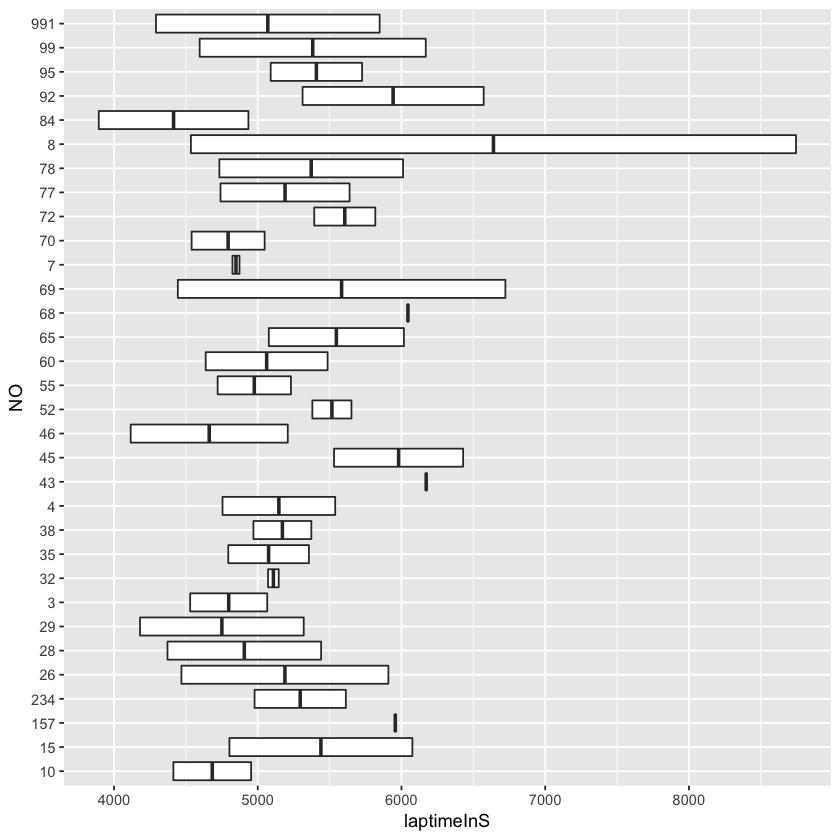

In [441]:
library(ggplot2)

p <- ggplot(full_df, aes(NO, laptimeInS))
p + geom_boxplot() + coord_flip()

To plot the classes, we need to know the classes. We can get this from the classification.

In [368]:
class_df = extract_tables('results/Dunlop Endurance Championship.pdf', pages = 62, header=F, guess=F, output='data.frame',
                    columns= list(c(35,56,84,101,269,364,389,432,465,498,525,560, 600)))[[1]]
class_df

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
Dun,lop,End,ura,nce Championship,,,,,,,,
RA,CE,4 - C,LA,SSIFICATION,,,,,,,,
POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON
1,55,1,1,JMH AutomotiveJohn SEALE / Marcus CLUTTON,Lamborghini Huracan,53,1:00:40.998,,,96.99,1:03.473,28
2,29,1,2,Simon Green MotorsportLee FROST / Lucky KHERA,McLaren 650s GT3,52,1:01:10.289,1 Lap,1 Lap,94.40,1:06.796,38
3,46,1,3,ING SportKevin CLARKE / Ryan LINDSAY,BMW Z4 GT3,52,1:01:16.370,1 Lap,6.081,94.24,1:07.209,15
4,10,2,1,JMH AutomotiveWayne MARRS / Charlie HOLLINGS,Ferrari 488 Challenge,52,1:01:18.594,1 Lap,2.224,94.19,1:06.646,45
5,28,2,2,SB Race EngineeringPaul BAILEY / Andy SCHULTZ,Ferrari 488 Challenge,52,1:01:27.027,1 Lap,8.433,93.97,1:06.778,38
6,7,2,3,FF CorseDavid MASON / Ross WYLIE,Ferrari 488 Challenge,51,1:01:18.459,2 Laps,1 Lap,92.38,1:04.774,4
7,70,3,1,Track-groupMarcus JEWELL / Lewis PLATO,Porsche 997 GT3,51,1:01:23.242,2 Laps,4.783,92.26,1:07.159,36


Note the exceptions... in a class, there may be `INV` (invited) cars.

Some rows may also overflow to second rows, especially in eg the `NOT CLASSIFIED` or `FASTEST LAP` sections.

Also note that the team and driver names are bunched in the main classification, but not in the other tables (not classified and fastest lap).

So we need to cope with that...

How about getting the column names from a specified row?

In [369]:
#colnames(df) <- as.character(unlist(df[1,]))
headerrow=3
print( as.character(unlist(classified_df[headerrow,])) )

#Ignore the rows up to an including the headerrow in the table
class_df[-(1:headerrow),][1:5,]
 

 [1] "3"                                   
 [2] "46"                                  
 [3] "1"                                   
 [4] "3"                                   
 [5] "ING SportKevin CLARKE / Ryan LINDSAY"
 [6] "BMW Z4 GT3"                          
 [7] "52"                                  
 [8] "1:01:16.370"                         
 [9] "1 Lap"                               
[10] "6.081"                               
[11] "94.24"                               
[12] "1:07.209"                            
[13] "15"                                  
[14] "1"                                   
[15] "FALSE"                               


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
4,1,55,1,1,JMH AutomotiveJohn SEALE / Marcus CLUTTON,Lamborghini Huracan,53,1:00:40.998,,,96.99,1:03.473,28
5,2,29,1,2,Simon Green MotorsportLee FROST / Lucky KHERA,McLaren 650s GT3,52,1:01:10.289,1 Lap,1 Lap,94.40,1:06.796,38
6,3,46,1,3,ING SportKevin CLARKE / Ryan LINDSAY,BMW Z4 GT3,52,1:01:16.370,1 Lap,6.081,94.24,1:07.209,15
7,4,10,2,1,JMH AutomotiveWayne MARRS / Charlie HOLLINGS,Ferrari 488 Challenge,52,1:01:18.594,1 Lap,2.224,94.19,1:06.646,45
8,5,28,2,2,SB Race EngineeringPaul BAILEY / Andy SCHULTZ,Ferrari 488 Challenge,52,1:01:27.027,1 Lap,8.433,93.97,1:06.778,38


Let's apply that:

In [370]:
names(class_df) <- as.character(unlist(class_df[headerrow,]))
class_df <- class_df[-(1:headerrow),]

class_df[1:5,]

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON
4,1,55,1,1,JMH AutomotiveJohn SEALE / Marcus CLUTTON,Lamborghini Huracan,53,1:00:40.998,,,96.99,1:03.473,28
5,2,29,1,2,Simon Green MotorsportLee FROST / Lucky KHERA,McLaren 650s GT3,52,1:01:10.289,1 Lap,1 Lap,94.40,1:06.796,38
6,3,46,1,3,ING SportKevin CLARKE / Ryan LINDSAY,BMW Z4 GT3,52,1:01:16.370,1 Lap,6.081,94.24,1:07.209,15
7,4,10,2,1,JMH AutomotiveWayne MARRS / Charlie HOLLINGS,Ferrari 488 Challenge,52,1:01:18.594,1 Lap,2.224,94.19,1:06.646,45
8,5,28,2,2,SB Race EngineeringPaul BAILEY / Andy SCHULTZ,Ferrari 488 Challenge,52,1:01:27.027,1 Lap,8.433,93.97,1:06.778,38


Let's also clean the class column of invited cars:

In [371]:
#Retain the original class column, including invite, and create a new clean column
class_df$CLASS = gsub(' INV', '', class_df$CL)
class_df$INV = endsWith(class_df$CL, ' INV')
class_df[10:15,]

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV
13,10,77,4 INV,1,Fox MotorsportMark MURFITT / Michael BROADHURST,Mercedes GT4 AMG,50,1:01:25.208,3 Laps,40.902,90.40,1:09.381,34,4,TRUE
14,11,32,3,3,SG RacingMark CUNNINGHAM / Peter CUNNINGHAM,Porsche 997 GT3 Cup,50,1:01:34.665,3 Laps,9.457,90.17,1:08.559,21,3,FALSE
15,12,234,4,1,Team ABBA RacingRichard NEARY / Sam NEARY,BMW M3 E46,50,1:01:50.959,3 Laps,16.294,89.77,1:09.066,13,4,FALSE
16,13,78,4,2,Maximum MotorsportTim DOCKER,VW Golf TCR,49,1:01:09.699,4 Laps,1 Lap,88.97,1:11.193,32,4,FALSE
17,14,38,4,3,Geoff Steel RacingSam ALLPASS,BMW M3 GTR,49,1:01:28.577,4 Laps,18.878,88.51,1:11.247,39,4,FALSE
18,15,99,4,4,DAT RacingGuy COLCLOUGH / Max COATES,Seat Cupra TCR,49,1:01:31.272,4 Laps,2.695,88.45,1:10.415,26,4,FALSE


Next up, how can we split the data from the classification PDF into the classified, not classified, and fastest time datasets?

In [372]:
allInOne <- class_df %>% unite('allInOne',colnames(class_df), sep='')
#Remove all spaces - we don't know where a reserved word or phrase may be split
allInOne$allInOne <- gsub("\\s", "", allInOne$allInOne) 
allInOne

,allInOne
4,15511JMHAutomotiveJohnSEALE/MarcusCLUTTONLamborghiniHuracan531:00:40.99896.991:03.473281FALSE
5,22912SimonGreenMotorsportLeeFROST/LuckyKHERAMcLaren650sGT3521:01:10.2891Lap1Lap94.401:06.796381FALSE
6,34613INGSportKevinCLARKE/RyanLINDSAYBMWZ4GT3521:01:16.3701Lap6.08194.241:07.209151FALSE
7,41021JMHAutomotiveWayneMARRS/CharlieHOLLINGSFerrari488Challenge521:01:18.5941Lap2.22494.191:06.646452FALSE
8,52822SBRaceEngineeringPaulBAILEY/AndySCHULTZFerrari488Challenge521:01:27.0271Lap8.43393.971:06.778382FALSE
9,6723FFCorseDavidMASON/RossWYLIEFerrari488Challenge511:01:18.4592Laps1Lap92.381:04.77442FALSE
10,77031Track-groupMarcusJEWELL/LewisPLATOPorsche997GT3511:01:23.2422Laps4.78392.261:07.159363FALSE
11,899132VallugaRacingAdamHATFIELD/AdamKNIGHTPorsche991511:01:34.9792Laps11.73791.961:07.895413FALSE
12,9814MacGRacingJonnyMACGREGOR/BenSHARICHTaranis501:00:44.3063Laps1Lap91.411:06.702281FALSE
13,10774INV1FoxMotorsportMarkMURFITT/MichaelBROADHURSTMercedesGT4AMG501:01:25.2083Laps40.90290.401:09.381344TRUE


We can now lookup rows that separate different sections of the classification report.

In [373]:
unclassified_row <- which(grepl("NOTCLASSIFIED", allInOne$allInOne))
unclassified_row

[1] 24

In [374]:
fastestLap_row <- which(grepl("FASTESTLAP", allInOne$allInOne))
fastestLap_row

[1] 43

In [416]:
class_df[,'NO']

[1] "55"      "29"      "46"      "10"      "28"      "7"       "70"     
 [8] "991"     "8"       "77"      "32"      "234"     "78"      "38"     
[15] "99"      "26"      "95"      "60"      "69"      "157"     "72"     
[22] "15"      "68"      ""        "35"      ""        "92"      ""       
[29] "3"       ""        "84"      ""        "45"      ""        "52"     
[36] ""        "4"       ""        "65"      ""        "43"      ""       
[43] ""        "55"      ""        "7"       ""        "70"      ""       
[50] "234"     ""        "77"      ""        "157"     ""        ""       
[57] "her / T" "e resu"  "Of Co"   "lts ca"

We can now filter the classification to give just the classified cars:

In [375]:
classified_df <- class_df[1:(unclassified_row-1),]
classified_df

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV
4,1,55,1,1,JMH AutomotiveJohn SEALE / Marcus CLUTTON,Lamborghini Huracan,53,1:00:40.998,,,96.99,1:03.473,28,1,FALSE
5,2,29,1,2,Simon Green MotorsportLee FROST / Lucky KHERA,McLaren 650s GT3,52,1:01:10.289,1 Lap,1 Lap,94.40,1:06.796,38,1,FALSE
6,3,46,1,3,ING SportKevin CLARKE / Ryan LINDSAY,BMW Z4 GT3,52,1:01:16.370,1 Lap,6.081,94.24,1:07.209,15,1,FALSE
7,4,10,2,1,JMH AutomotiveWayne MARRS / Charlie HOLLINGS,Ferrari 488 Challenge,52,1:01:18.594,1 Lap,2.224,94.19,1:06.646,45,2,FALSE
8,5,28,2,2,SB Race EngineeringPaul BAILEY / Andy SCHULTZ,Ferrari 488 Challenge,52,1:01:27.027,1 Lap,8.433,93.97,1:06.778,38,2,FALSE
9,6,7,2,3,FF CorseDavid MASON / Ross WYLIE,Ferrari 488 Challenge,51,1:01:18.459,2 Laps,1 Lap,92.38,1:04.774,4,2,FALSE
10,7,70,3,1,Track-groupMarcus JEWELL / Lewis PLATO,Porsche 997 GT3,51,1:01:23.242,2 Laps,4.783,92.26,1:07.159,36,3,FALSE
11,8,991,3,2,Valluga RacingAdam HATFIELD / Adam KNIGHT,Porsche 991,51,1:01:34.979,2 Laps,11.737,91.96,1:07.895,41,3,FALSE
12,9,8,1,4,MacG RacingJonny MACGREGOR / Ben SHARICH,Taranis,50,1:00:44.306,3 Laps,1 Lap,91.41,1:06.702,28,1,FALSE
13,10,77,4 INV,1,Fox MotorsportMark MURFITT / Michael BROADHURST,Mercedes GT4 AMG,50,1:01:25.208,3 Laps,40.902,90.40,1:09.381,34,4,TRUE


#### Coping with merged team and driver names
The team and driver details may be merged into each other in the main classification. We should be able to recover that from other sheets, but it's a real pain here unless we use a heuristic of splitting on camelcase.

In [329]:
#https://stackoverflow.com/a/43706490/454773
paste(strsplit('JMH AutomotiveJohn SEALE / Marcus CLUTTON', "(?<=[a-z])(?=[A-Z])", perl = TRUE)[[1]], collapse=' :: ')

[1] "JMH Automotive :: John SEALE / Marcus CLUTTON"

There are, however, likely to be exceptions, for example if the latter part of a team name is in uppercase:-(

In [330]:
paste(strsplit('Team BRITMartyn COMPTON / Warren MCKINLAY', "(?<=[a-z])(?=[A-Z])", perl = TRUE)[[1]], collapse=' :: ')

[1] "Team BRITMartyn COMPTON / Warren MCKINLAY"

If we can get the team names from elsewhere, in the same format, we could just replace them out of this column.

Or we can use another heuristic: split if we have two or more uppercase followed by a lowercase.

Or maybe we should instead take a step back and thing just about pattern matching on the string.

VIa @graemefowler, this seems to work for some of the cases I have so far? Rather than try to come up with a genral splitter, parse the string using structure we know is there... Doh!

We also need to be able to cope with situations where there is only a single driver.

In [393]:
#Team XYZJohn SMITH / Jane SMITH
#TEAM RacersJohn SMITH / Jane SMITH
#John McMahon RacingJohn SMITH / Jane SMITH


print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "TEAM RacersJohn SMITH / Jane SMITH", perl=TRUE))

print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "Team XYZJohn SMITH / Jane SMITH", perl=TRUE))

print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "Team XYZJohn SMITH-JONES / Jane SMITH", perl=TRUE))


print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "Team-xyzJohn SMITH / Jane SMITH", perl=TRUE))

print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "John McMahon RacingJohn SMITH / Jane SMITH", perl=TRUE))

print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "Team XYZJohn SMITH", perl=TRUE))

print(gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2",
           "Team-XYZJohn SMITH", perl=TRUE))

[1] "TEAM Racers :: John SMITH / Jane SMITH"
[1] "Team XYZ :: John SMITH / Jane SMITH"
[1] "Team XYZ :: John SMITH-JONES / Jane SMITH"
[1] "Team-xyz :: John SMITH / Jane SMITH"
[1] "John McMahon Racing :: John SMITH / Jane SMITH"
[1] "Team XYZ :: John SMITH"
[1] "Team-XYZ :: John SMITH"


Let's add in the team / driver splitter:

In [394]:
classified_df['TEAMDRIVERS'] <- classified_df['TEAM / DRIVERS'] %>%
    apply( 2, function(x) gsub("^(.+[A-Z-][a-zA-Z]+)([A-Z]\\w+ [A-Z]+( \\/.+)?)", "\\1 :: \\2", x))

classified_df %>%  separate('TEAMDRIVERS', into=c('TEAM','DRIVERS'),sep=' :: ') 

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV,TEAM,DRIVERS
4,1,55,1,1,JMH AutomotiveJohn SEALE / Marcus CLUTTON,Lamborghini Huracan,53,1:00:40.998,,,96.99,1:03.473,28,1,FALSE,JMH Automotive,John SEALE / Marcus CLUTTON
5,2,29,1,2,Simon Green MotorsportLee FROST / Lucky KHERA,McLaren 650s GT3,52,1:01:10.289,1 Lap,1 Lap,94.40,1:06.796,38,1,FALSE,Simon Green Motorsport,Lee FROST / Lucky KHERA
6,3,46,1,3,ING SportKevin CLARKE / Ryan LINDSAY,BMW Z4 GT3,52,1:01:16.370,1 Lap,6.081,94.24,1:07.209,15,1,FALSE,ING Sport,Kevin CLARKE / Ryan LINDSAY
7,4,10,2,1,JMH AutomotiveWayne MARRS / Charlie HOLLINGS,Ferrari 488 Challenge,52,1:01:18.594,1 Lap,2.224,94.19,1:06.646,45,2,FALSE,JMH Automotive,Wayne MARRS / Charlie HOLLINGS
8,5,28,2,2,SB Race EngineeringPaul BAILEY / Andy SCHULTZ,Ferrari 488 Challenge,52,1:01:27.027,1 Lap,8.433,93.97,1:06.778,38,2,FALSE,SB Race Engineering,Paul BAILEY / Andy SCHULTZ
9,6,7,2,3,FF CorseDavid MASON / Ross WYLIE,Ferrari 488 Challenge,51,1:01:18.459,2 Laps,1 Lap,92.38,1:04.774,4,2,FALSE,FF Corse,David MASON / Ross WYLIE
10,7,70,3,1,Track-groupMarcus JEWELL / Lewis PLATO,Porsche 997 GT3,51,1:01:23.242,2 Laps,4.783,92.26,1:07.159,36,3,FALSE,Track-group,Marcus JEWELL / Lewis PLATO
11,8,991,3,2,Valluga RacingAdam HATFIELD / Adam KNIGHT,Porsche 991,51,1:01:34.979,2 Laps,11.737,91.96,1:07.895,41,3,FALSE,Valluga Racing,Adam HATFIELD / Adam KNIGHT
12,9,8,1,4,MacG RacingJonny MACGREGOR / Ben SHARICH,Taranis,50,1:00:44.306,3 Laps,1 Lap,91.41,1:06.702,28,1,FALSE,MacG Racing,Jonny MACGREGOR / Ben SHARICH
13,10,77,4 INV,1,Fox MotorsportMark MURFITT / Michael BROADHURST,Mercedes GT4 AMG,50,1:01:25.208,3 Laps,40.902,90.40,1:09.381,34,4,TRUE,Fox Motorsport,Mark MURFITT / Michael BROADHURST


And the unclassified cars:

In [431]:
unclassified_df <- class_df[(unclassified_row+1):(fastestLap_row-1),]
unclassified_df

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV
28,DNF,35,4,,CTR Alfatune,Seat Leon TCR,42,53:01.784,11 Laps,,87.95,1:11.535,6,4,FALSE
29,,,,,John CLONIS / Chris BENTLEY,,,,,,,,,,FALSE
30,DNF,92,4,,Paul Calladine Motorsport,Ginetta G50 GT4,37,56:47.204,16 Laps,5 Laps,72.35,1:11.643,36,4,FALSE
31,,,,,Paul CALLADINE,,,,,,,,,,FALSE
32,DNF,3,1,,JPR Motorsport,Saker RAPX,22,25:19.851,31 Laps,15 Laps,96.45,1:07.510,6,1,FALSE
33,,,,,Paul ROSE,,,,,,,,,,FALSE
34,DNF,84,1,,VR Motorsport,Praga R1T,16,20:28.038,37 Laps,6 Laps,86.81,1:03.672,11,1,FALSE
35,,,,,Tim GRAY,,,,,,,,,,FALSE
36,DNF,45,5,,Derek McMahon Racing,Honda Civic,16,21:40.593,37 Laps,1:12.555,81.97,1:17.750,15,5,FALSE
37,,,,,Arthur MCMAHON,,,,,,,,,,FALSE


In this case, the teams and drivers are split out. Can we grab the drivers on the off rows?

In [432]:
unclassified_drivers <- unclassified_df[unclassified_df['NO']=='','TEAM / DRIVERS']
unclassified_drivers

[1] "John CLONIS / Chris BENTLEY" "Paul CALLADINE"             
[3] "Paul ROSE"                   "Tim GRAY"                   
[5] "Arthur MCMAHON"              "Rob BAKER / Lucas NANETTI"  
[7] "Steve HARRIS"                "Alan PURBRICK / David BRISE"
[9] "Piers REID"

In [433]:
unclassified_df <- unclassified_df[unclassified_df['NO']!='',]
unclassified_df['DRIVERS'] <- unclassified_drivers
unclassified_df <- unclassified_df %>% rename(TEAM = 'TEAM / DRIVERS')
unclassified_df

,POS,NO,CL,PIC,TEAM,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV,DRIVERS
28,DNF,35,4,,CTR Alfatune,Seat Leon TCR,42,53:01.784,11 Laps,,87.95,1:11.535,6,4,FALSE,John CLONIS / Chris BENTLEY
30,DNF,92,4,,Paul Calladine Motorsport,Ginetta G50 GT4,37,56:47.204,16 Laps,5 Laps,72.35,1:11.643,36,4,FALSE,Paul CALLADINE
32,DNF,3,1,,JPR Motorsport,Saker RAPX,22,25:19.851,31 Laps,15 Laps,96.45,1:07.510,6,1,FALSE,Paul ROSE
34,DNF,84,1,,VR Motorsport,Praga R1T,16,20:28.038,37 Laps,6 Laps,86.81,1:03.672,11,1,FALSE,Tim GRAY
36,DNF,45,5,,Derek McMahon Racing,Honda Civic,16,21:40.593,37 Laps,1:12.555,81.97,1:17.750,15,5,FALSE,Arthur MCMAHON
38,DNF,52,5,,S2Smarts,Smart ForFour,15,20:17.898,38 Laps,1 Lap,82.06,1:17.831,12,5,FALSE,Rob BAKER / Lucas NANETTI
40,DNF,4,1,,JPR Motorsport,Saker RAPX,14,17:19.900,39 Laps,1 Lap,89.70,1:08.281,10,1,FALSE,Steve HARRIS
42,DNF,65,2,,ALP Racing,Saker RAPX,12,31:35.421,41 Laps,2 Laps,42.18,1:10.864,11,2,FALSE,Alan PURBRICK / David BRISE
44,DNF,43,4,,Butler Motorsport,BMW M3 E46,4,5:21.315,49 Laps,8 Laps,82.94,1:14.564,3,4,FALSE,Piers REID


We can also pull out the fastest laps table. This looks to return the fastest in each class, plus any invited entries that are actually fastest in class.

Do this in two steps: get the rows from fastest laps down, then try to figure out which rows to drop at the end.

In [470]:
fastestLap_df <- class_df[(fastestLap_row+1):nrow(class_df),]
fastestLap_df

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV
47,,55,1,,JMH Automotive,Lamborghini Huracan,28,1:03.473,10,4.97 mph,1,68.94 kph,,1,FALSE
48,,,,,John SEALE / Marcus CLUTTON,,,,,,,,,,FALSE
49,,7,2,,FF Corse,Ferrari 488 Challenge,4,1:04.774,10,2.86 mph,1,65.55 kph,,2,FALSE
50,,,,,David MASON / Ross WYLIE,,,,,,,,,,FALSE
51,,70,3,,Track-group,Porsche 997 GT3,36,1:07.159,9,9.21 mph,1,59.67 kph,,3,FALSE
52,,,,,Marcus JEWELL / Lewis PLATO,,,,,,,,,,FALSE
53,,234,4,,Team ABBA Racing,BMW M3 E46,13,1:09.066,9,6.47 mph,1,55.26 kph,,4,FALSE
54,,,,,Richard NEARY / Sam NEARY,,,,,,,,,,FALSE
55,,77,4 INV,,Fox Motorsport,Mercedes GT4 AMG,34,1:09.381,9,6.03 mph,1,54.55 kph,,4,TRUE
56,,,,,Mark MURFITT / Michael BROADHURST,,,,,,,,,,FALSE


In [471]:
blank_rows <- which(fastestLap_df[,'TEAM / DRIVERS']=='')
blank_rows

[1] 13 16

In [472]:
fastestLap_df <- fastestLap_df[1:(blank_rows[1]-1),]
fastestLap_df

,POS,NO,CL,PIC,TEAM / DRIVERS,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV
47,,55,1,,JMH Automotive,Lamborghini Huracan,28,1:03.473,10,4.97 mph,1,68.94 kph,,1,FALSE
48,,,,,John SEALE / Marcus CLUTTON,,,,,,,,,,FALSE
49,,7,2,,FF Corse,Ferrari 488 Challenge,4,1:04.774,10,2.86 mph,1,65.55 kph,,2,FALSE
50,,,,,David MASON / Ross WYLIE,,,,,,,,,,FALSE
51,,70,3,,Track-group,Porsche 997 GT3,36,1:07.159,9,9.21 mph,1,59.67 kph,,3,FALSE
52,,,,,Marcus JEWELL / Lewis PLATO,,,,,,,,,,FALSE
53,,234,4,,Team ABBA Racing,BMW M3 E46,13,1:09.066,9,6.47 mph,1,55.26 kph,,4,FALSE
54,,,,,Richard NEARY / Sam NEARY,,,,,,,,,,FALSE
55,,77,4 INV,,Fox Motorsport,Mercedes GT4 AMG,34,1:09.381,9,6.03 mph,1,54.55 kph,,4,TRUE
56,,,,,Mark MURFITT / Michael BROADHURST,,,,,,,,,,FALSE


In [473]:
fastestLap_drivers <- fastestLap_df[fastestLap_df['NO']=='','TEAM / DRIVERS']
fastestLap_drivers

[1] "John SEALE / Marcus CLUTTON"       "David MASON / Ross WYLIE"         
[3] "Marcus JEWELL / Lewis PLATO"       "Richard NEARY / Sam NEARY"        
[5] "Mark MURFITT / Michael BROADHURST" "Barry MCMAHON"

In [474]:
fastestLap_df <- fastestLap_df[fastestLap_df['NO']!='',]
fastestLap_df['DRIVERS'] <- fastestLap_drivers
fastestLap_df <- fastestLap_df %>% rename(TEAM = 'TEAM / DRIVERS')
fastestLap_df

,POS,NO,CL,PIC,TEAM,CAR,LAPS,TIME,GAP,DIFF,MPH,BEST,ON,CLASS,INV,DRIVERS
47,,55,1,,JMH Automotive,Lamborghini Huracan,28,1:03.473,10,4.97 mph,1,68.94 kph,,1,FALSE,John SEALE / Marcus CLUTTON
49,,7,2,,FF Corse,Ferrari 488 Challenge,4,1:04.774,10,2.86 mph,1,65.55 kph,,2,FALSE,David MASON / Ross WYLIE
51,,70,3,,Track-group,Porsche 997 GT3,36,1:07.159,9,9.21 mph,1,59.67 kph,,3,FALSE,Marcus JEWELL / Lewis PLATO
53,,234,4,,Team ABBA Racing,BMW M3 E46,13,1:09.066,9,6.47 mph,1,55.26 kph,,4,FALSE,Richard NEARY / Sam NEARY
55,,77,4 INV,,Fox Motorsport,Mercedes GT4 AMG,34,1:09.381,9,6.03 mph,1,54.55 kph,,4,TRUE,Mark MURFITT / Michael BROADHURST
57,,157,5,,Derek McMahon Racing,Alfa Romeo 156 T,3,1:13.281,9,0.92 mph,1,46.33 kph,,5,FALSE,Barry MCMAHON


#### Lap Analysis Pages

The `LAP ANALYSIS` pages record the laptimes for each vehicle, by vehicle. The data is arranged in two columns. Within a column, a vehicle is identified, their laptimes given, and the next vehicle identified. Times for a given vehicle may overflow from one column to the next, or from the second column on the page into the first column of the next.

In [522]:
extract_tables('results/Dunlop Endurance Championship.pdf', pages = 41, 
                          header=F, guess=F, output='data.frame')[[1]][1:10,]

V1,V2,V3,V4
Dunlop Endurance Championship,,,
RACE 1 - LAP ANALYSIS,,,
DIFF = Difference To Personal Best Lap,,DIFF = Difference To Personal Best Lap,
P1 84 VR Motorsport,,9 - 1:06.532 3.409 100.15,13:39:09.585
,,10 - 1:07.025 3.902 99.41,13:40:16.610
LAP LAP TIME DIFF MPH,TIME OF DAY,11 - 1:07.662 4.539 98.47,13:41:24.272
,,12 - 1:07.261 4.138 99.06,13:42:31.533
1 - 1:09.388 5.929 96.02,13:25:53.496,,
,,13 - 1:06.925 3.802 99.56,13:43:38.458
2 - 1:04.407 0.948 103.45,13:26:57.903,,


To scrape this table, we need to:

- identify the vehicle;
- identify the laptimes recorded for the vehicle.

The data provided for each lap is:

- lap number;
- lap time;
- laptime difference to personal best lap;
- speed (average speed for the lap);
- time of day.

The vehicle's three bast lap times are annotated, as are pit laps (that is, inlaps). The outlap will be significantly longer and includes the pit stop and pit lane loss times. Inlap times may be less than the fastest lap time if the time is set near the start of the pit lane.

In [ ]:
extract_tables('results/Dunlop Endurance Championship.pdf', pages = 41, header=F, guess=F, output='data.frame',
                    columns= list(c(52,98,115,168,210,300,352,396,419,467,508, 600)))[[1]]

First, let's split everything into two columns and try to pull out driver names and the rows they are associated with.

The driver rows start with a `P` for the position.

In [82]:
lap_analysis_vehicle = extract_tables('results/Dunlop Endurance Championship.pdf', pages = 41, header=F, guess=F, output='data.frame',
                    columns= list(c(300, 600)))[[1]]

lap_analysis_vehicle = reshape(lap_analysis_vehicle, direction="long", new.row.names =1:10000,
    varying=list(c(1,2)), timevar='Col') 


vehicle_rows = which(grepl('P[0-9]+',trimws(lap_analysis_vehicle[,'V1'])))
lap_analysis_vehicle[vehicle_rows,'V1']


[1] "P1 84 VR Motorsport"  "P2 55 JMH Automotive" "P3 8 MacG Racing"

In [139]:
teams <- data.frame(lap_analysis_vehicle[vehicle_rows,'V1']) %>% extract(1, c('POS','NO','TEAM'), 
                                                                regex = "(P[0-9]+) ([0-9]+) (.*)")

teams

POS,NO,TEAM
P1,84,VR Motorsport
P2,55,JMH Automotive
P3,8,MacG Racing


In [126]:
#Generate the pairwise ranges
#https://stackoverflow.com/a/41206700/454773
lap_ranges <- rbind(vehicle_rows[-length(vehicle_rows)], vehicle_rows[-1])
lap_ranges <- split(lap_ranges, col(lap_ranges))

Now let's split the data into two groups of 6 columns, and try to split the data out by driver.

We have the rows that mark each drive, so use that as the first approximate pass.

This first attempt is just on a single page.

In [179]:
lap_analysis = extract_tables('results/Dunlop Endurance Championship.pdf', pages = 41,
                              header=F, guess=F, output='data.frame',
                              columns= list(c(52,98,115,168,210,300,352,396,419,467,508, 600)))[[1]]

lap_analysis_cols = c('LAP','LAP TIME','ANN','DIFF','MPH','TIME OF DAY')
names(lap_analysis) <- make.unique(rep(lap_analysis_cols,2))

lap_analysis <- reshape(lap_analysis, direction="long", new.row.names =1:10000,
    varying=list(c(1,7), c(2,8),c(3,9),c(4,10),c(5,11),c(6,12)), timevar='Col')

full_lap_analysis <- data.frame()
#Need to autsplit into groups
for (lap_range in lap_ranges){
    full_lap_analysis <- rbind(full_lap_analysis, lap_analysis[lap_range[1]:(lap_range[2]-1),] )

    }

#Clear blank rows and head row
full_lap_analysis <- full_lap_analysis[!(full_lap_analysis$LAP %in% c("","LAP")) , ]

#Merge in driver details

full_lap_analysis <- full_lap_analysis %>%
                    mutate(POS = str_extract(LAP, "(P[0-9]+)")) %>%
                    fill(POS)  %>% 
                    inner_join(teams) %>%
                    #Drop the Col and id columns
                    select(-c(id,Col)) %>%
                    #Drop the position header rows
                    filter(!startsWith(LAP,'P')) %>%
                    #Tidy the lap column
                    mutate(LAP = str_extract(LAP, "([0-9]+) ")) %>%
                    #Tidy the POS column
                    mutate(POS = str_extract(POS, "([0-9]+)"))

full_lap_analysis#[1:10,]


Joining, by = "POS"


LAP,LAP TIME,ANN,DIFF,MPH,TIME OF DAY,POS,NO,TEAM
1,1:09.388,,5.929,96.02,13:25:53.496,1,84,VR Motorsport
2,1:04.407,,0.948,103.45,13:26:57.903,1,84,VR Motorsport
3,2:16.677,,1:13.218,48.75,13:29:14.580,1,84,VR Motorsport
4,2:26.874,,1:23.415,45.36,13:31:41.454,1,84,VR Motorsport
5,2:19.108,,1:15.649,47.89,13:34:00.562,1,84,VR Motorsport
6,1:43.285,,39.826,64.51,13:35:43.847,1,84,VR Motorsport
7,1:05.280,,1.821,102.07,13:36:49.127,1,84,VR Motorsport
8,1:03.778,,0.319,104.47,13:37:52.905,1,84,VR Motorsport
9,1:03.459,(1),,105.00,13:38:56.364,1,84,VR Motorsport
10,1:05.094,,1.635,102.36,13:40:01.458,1,84,VR Motorsport


We now need to identify

Now let's tidy that up and apply it to several pages.

In [ ]:
#df$OUT = lag(df$PIT,1)

## Safety Car Laps

Can we identify those? They are highlighed in yellow on the PDFs but `tabulizer` doesn't flag that up in any way.

It looks like there is a *flag* history that we can draw on to detect this, at least in terms of time.

We can also get lap start time by lap number from the `Lap Chart` tables and build up a picture of the race from those times and the flag times.

In [468]:
extract_tables('results/Dunlop Endurance Championship.pdf', pages = 54, 
                          header=F, guess=F, output='data.frame')[[1]]


V1,V2,V3,V4
Dunlop Endurance Championship,,NA,
RACE 1 - STATISTICS,,NA,
Competitors Started 35,,NA,
Planned Start 2019-03-30 @ 13:25:00.000,,NA,
Actual Start 2019-03-30 @ 13:24:44.107,,NA,
Finish Time 2019-03-30 @ 14:25:22.253,,NA,
Track Length 1.8508mi.,,NA,
Total Laps 1453,,NA,
Total Distance Covered 2689.3533mi.,,NA,
Session Fastest Lap History,,NA,


## Comparing Driver Performance - In Class

To ensure balanced racing, race promoters need to ensure that cars and drivers are appropriately classed.

One way to check this is to compare racing lap times, which is to say laptimes:

- that are not PIT related (in-lap or out-lap);
- that are not completed under safety car or full course yellow flags.

Note that there other ways we might compare drivers:

- INLAP and OUTLAP times; (can we also get pit lane times somehow?)




In [229]:
extract_table_as_df(PDF, pages = 10, header=F)

V1,V2,V3
2019 Renault UK Clio Cup,,
QUALIFYING - ROUND 1 - SECTOR ANALYSIS,,
"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,P = Crossed Finish Line in Pit Lane,D = Time Disallowed",,
P11 11 Luke WARR Specialized Motorsport,,
IDEAL LAP TIME : 54.358 BEST LAP TIME : 54.489 DIFFERENCE : 0.131,,
LAP SECTOR 1 SECTOR 2 LAP TIME MPH,DIFF,TIME OF DAY
1 - OUTLAP 70.5 29.310 88.7 1:15.191 57.83,20.702,11:25:29.709
2 - 39.457 81.9 24.256 108.2 1:03.713 68.25,9.224,11:26:33.422
3 - 35.568 87.7 23.270 109.2 58.838 73.90,4.349,11:27:32.260
4 - 34.783 88.7 23.240 109.1 58.023 74.94,3.534,11:28:30.283


In [11]:
extract_tables("2019/191403cli.pdf", pages = 11)

1,21,DAVIS,95.8,21,DAVIS,113.9
2,12,LIDSEY,95.7,41,THOMPSON,112.7
3,71,COATES,95.3,62,YOUNG,112.5
4,62,YOUNG,95.3,23,HAMMERTON,112.5
5,41,THOMPSON,95.3,12,LIDSEY,112.4
6,9,EDWARDS,95.1,14,SPIRES,112.2
7,23,HAMMERTON,95.0,9,EDWARDS,112.2
8,5,COLBURN,95.0,5,COLBURN,111.8
9,14,SPIRES,94.6,71,COATES,110.9
10,29,ROBINSON,94.1,29,ROBINSON,110.7
11,11,WARR,93.4,11,WARR,110.0


In [12]:
extract_tables(PDF, pages = 12)

,,,,,,,,,PERFECT LAP,52.324,,
1,71,COATES,31.138,62,YOUNG,21.186,1,71,COATES,52.351,52.366,0.015
2,23,HAMMERTON,31.174,12,LIDSEY,21.206,2,62,YOUNG,52.384,52.409,0.025
3,62,YOUNG,31.198,71,COATES,21.213,3,12,LIDSEY,52.429,52.499,0.070
4,12,LIDSEY,31.223,21,DAVIS,21.266,4,23,HAMMERTON,52.466,52.466,0.000
5,21,DAVIS,31.262,5,COLBURN,21.282,5,21,DAVIS,52.528,52.580,0.052
6,41,THOMPSON,31.274,23,HAMMERTON,21.292,6,5,COLBURN,52.607,52.607,0.000
7,5,COLBURN,31.325,9,EDWARDS,21.322,7,41,THOMPSON,52.643,52.754,0.111
8,14,SPIRES,31.337,29,ROBINSON,21.366,8,14,SPIRES,52.757,52.877,0.120
9,9,EDWARDS,31.531,41,THOMPSON,21.369,9,9,EDWARDS,52.853,52.900,0.047
10,29,ROBINSON,31.710,14,SPIRES,21.420,10,29,ROBINSON,53.076,53.090,0.014


In [18]:
extract_tables(PDF, pages = 14)

NO,CL,NAME,LAP TIME,TIME OF DAY,LAP,VEHICLE
62,G,Jack YOUNG,58.002,11:26:12.149,2,M.R.M
62,G,Jack YOUNG,55.840,11:27:07.990,3,M.R.M
71,,Max COATES,55.778,11:27:18.963,3,Team Hard
23,G,Ethan HAMMERTON,55.358,11:27:19.258,3,Team Hard
62,G,Jack YOUNG,54.933,11:28:02.921,4,M.R.M
71,,Max COATES,54.424,11:28:13.386,4,Team Hard
62,G,Jack YOUNG,53.790,11:28:56.712,5,M.R.M
71,,Max COATES,53.725,11:30:01.022,6,Team Hard
62,G,Jack YOUNG,53.606,11:30:44.174,7,M.R.M
62,G,Jack YOUNG,53.236,11:31:37.409,8,M.R.M


In [20]:
extract_tables(PDF, pages = 15)

NO,NAME,LAP TIME,TIME OF DAY,LAP,VEHICLE
21,Ben DAVIS,59.738,11:26:14.775,2,R-Tech Welding with M.R.M
12,Brett LIDSEY,59.559,11:26:26.047,2,M.R.M
41,Aaron THOMPSON,59.335,11:26:26.624,2,Westbourne Motorsport
14,Anton SPIRES,59.110,11:26:27.060,2,Westbourne Motorsport
21,Ben DAVIS,56.989,11:27:11.762,3,R-Tech Welding with M.R.M
71,Max COATES,55.778,11:27:18.963,3,Team Hard
71,Max COATES,54.424,11:28:13.386,4,Team Hard
71,Max COATES,53.910,11:29:07.296,5,Team Hard
71,Max COATES,53.725,11:30:01.022,6,Team Hard
71,Max COATES,53.215,11:31:48.171,8,Team Hard


In [21]:
extract_tables(PDF, pages = 16)

NO,NAME,LAP TIME,TIME OF DAY,LAP,VEHICLE
62,Jack YOUNG,58.002,11:26:12.149,2,M.R.M
62,Jack YOUNG,55.840,11:27:07.990,3,M.R.M
23,Ethan HAMMERTON,55.358,11:27:19.258,3,Team Hard
62,Jack YOUNG,54.933,11:28:02.921,4,M.R.M
23,Ethan HAMMERTON,54.437,11:28:13.695,4,Team Hard
62,Jack YOUNG,53.790,11:28:56.712,5,M.R.M
62,Jack YOUNG,53.606,11:30:44.174,7,M.R.M
62,Jack YOUNG,53.236,11:31:37.409,8,M.R.M
62,Jack YOUNG,52.970,11:32:30.381,9,M.R.M
62,Jack YOUNG,52.697,11:43:35.421,14,M.R.M


In [24]:
extract_tables(PDF, pages = 19)

POS,NO,CL,PIC,NAME,NAT,ENTRY,LAPS,TIME,GAP,DIFF,MPH,BEST,ON
1,71,,1,Max COATES,GBR,Team Hard,19,18:53.152,,,72.91,58.808,3
2,62,G,1,Jack YOUNG,GBR,M.R.M,19,18:53.503,0.351,0.351,72.89,58.989,3
3,12,,2,Brett LIDSEY,GBR,M.R.M,19,19:03.496,10.344,9.993,72.25,59.573,5
4,23,G,2,Ethan HAMMERTON,GBR,Team Hard,19,19:04.060,10.908,0.564,72.21,59.581,5
5,9,,3,Jade EDWARDS,GBR,Team Hard,19,19:04.414,11.262,0.354,72.19,59.427,7
6,41,,4,Aaron THOMPSON,GBR,Westbourne Motorsport,19,19:13.863,20.711,9.449,71.60,59.588,4
7,29,G,3,Finlay ROBINSON,GBR,Westbourne Motorsport,19,19:14.184,21.032,0.321,71.58,59.507,2
8,21,,5,Ben DAVIS,GBR,R-Tech Welding with M.R.M,19,19:14.352,21.200,0.168,71.57,59.569,4
9,5,G,4,Ben COLBURN,GBR,Westbourne Motorsport,19,19:15.150,21.998,0.798,71.52,59.672,3
10,11,,6,Luke WARR,GBR,Specialized Motorsport,19,19:34.355,41.203,19.205,70.35,1:00.634,12


In [28]:
#Will need tidying
extract_tables(PDF, pages = 20:23)

"SECTOR 1 = FL to I1,SECTOR 2 = I1 to FL,DIFF = Difference To Personal Best Lap,",,,"P = Crossed Finish Line in Pit Lane,",D = Time Disallowed,,
P1 71 Max COATES,,,Team Hard,,,
IDEAL LAP TIME : 58.733 BEST LAP TIME : 58.808,,,DIFFERENCE : 0.075,,,
LAP SECTOR 1 SECTOR 2,,,LAP TIME,MPH,DIFF,TIME OF DAY
1 - 89.0 24.253 106.1,,,1:05.231,66.66,6.423,16:55:53.773
2 - 35.155 89.2 23.929 107.5,,,59.084,73.60,0.276,16:56:52.857
3 - 34.891 89.5 23.917 107.3,,,58.808 (1),73.94,,16:57:51.665
4 - 34.940 89.0 24.076 107.2,,,59.016,73.68,0.208,16:58:50.681
5 - 34.979 89.3 24.032 107.0,,,59.011 (3),73.69,0.203,16:59:49.692
6 - 34.977 89.4 24.068 107.0,,,59.045,73.64,0.237,17:00:48.737
7 - 35.100 88.8 24.130 107.3,,,59.230,73.41,0.422,17:01:47.967


In [29]:
extract_tables(PDF, pages = 24)

1,62,YOUNG,90.6,29,ROBINSON,110.7
2,23,HAMMERTON,90.4,9,EDWARDS,110.3
3,12,LIDSEY,90.1,21,DAVIS,110.3
4,21,DAVIS,90.0,23,HAMMERTON,110.1
5,71,COATES,89.9,5,COLBURN,109.8
6,41,THOMPSON,89.9,12,LIDSEY,109.6
7,5,COLBURN,89.9,41,THOMPSON,109.4
8,29,ROBINSON,89.8,62,YOUNG,109.1
9,9,EDWARDS,89.3,11,WARR,108.0
10,11,WARR,89.0,71,COATES,107.5


In [30]:
extract_tables(PDF, pages = 25)

,,,,,,,,,PERFECT LAP,58.578,,
1,71,COATES,34.816,9,EDWARDS,23.762,1,71,COATES,58.733,58.808,0.075
2,62,YOUNG,34.843,12,LIDSEY,23.797,2,62,YOUNG,58.806,58.989,0.183
3,21,DAVIS,35.235,29,ROBINSON,23.840,3,9,EDWARDS,59.197,59.427,0.230
4,23,HAMMERTON,35.305,71,COATES,23.917,4,12,LIDSEY,59.258,59.573,0.315
5,41,THOMPSON,35.356,62,YOUNG,23.963,5,23,HAMMERTON,59.332,59.581,0.249
6,5,COLBURN,35.418,5,COLBURN,23.965,6,41,THOMPSON,59.350,59.588,0.238
7,9,EDWARDS,35.435,41,THOMPSON,23.994,7,29,ROBINSON,59.371,59.507,0.136
8,12,LIDSEY,35.461,23,HAMMERTON,24.027,8,5,COLBURN,59.383,59.672,0.289
9,29,ROBINSON,35.531,21,DAVIS,24.334,9,21,DAVIS,59.569,59.569,0.000
10,11,WARR,36.168,11,WARR,24.466,10,11,WARR,1:00.634,1:00.634,0.000


In [31]:
extract_tables(PDF, pages = 26:29)

LAP 1 @ 16:55:53.773,,LAP 2 @ 16:56:52.857,,LAP 3 @ 16:57:51.665,,LAP 4 @ 16:58:50.681,,LAP 5 @ 16:59:49.692,
NO BEHIND,LAP TIME,NO BEHIND,LAP TIME,NO BEHIND,LAP TIME,NO BEHIND,LAP TIME,NO BEHIND,LAP TIME
71,1:05.231,71,59.084,71,58.808,71,59.016,71,59.011
62 0.048,1:05.279,62 0.677,59.713,62 0.858,58.989,62 1.053,59.211,62 1.049,59.007
12 0.304,1:05.535,12 0.887,59.667,12 1.825,59.746,12 2.426,59.617,12 2.988,59.573
23 0.911,1:06.142,23 1.494,59.667,23 2.487,59.801,23 3.093,59.622,23 3.663,59.581
9 1.321,1:06.552,9 1.842,59.605,9 2.839,59.805,9 3.458,59.635,9 4.112,59.665
5 1.465,1:06.696,5 2.448,1:00.067,5 3.312,59.672,5 4.102,59.806,41 5.441,1:00.245
41 1.943,1:07.174,41 2.792,59.933,41 3.635,59.651,41 4.207,59.588,29 5.650,59.931
21 2.762,1:07.993,29 3.236,59.507,29 4.168,59.740,29 4.730,59.578,5 6.017,1:00.926
29 2.813,1:08.044,21 4.628,1:00.950,21 5.770,59.950,21 6.323,59.569,21 7.086,59.774


In [35]:
extract_tables(PDF, pages = 32)

71,Max COATES,1:05.231,16:55:53.789,1,Team Hard
71,Max COATES,59.084,16:56:52.873,2,Team Hard
71,Max COATES,58.808,16:57:51.682,3,Team Hard
TYPE,TIME OF DAY,TYPE,COUNT,TOTAL LAPS,TOTAL TIME
GREEN,16:54:48.541,Green,1,18,18:51.439
FINISH,17:13:39.980,Red,0,0,0.000
,,Safety Car,0,0,0.000
,,FCY,0,0,0.000


In [36]:
extract_tables(PDF, pages = 33)

71,Max COATES,1:05.231,16:55:53.789,1,Team Hard
71,Max COATES,59.084,16:56:52.873,2,Team Hard
71,Max COATES,58.808,16:57:51.682,3,Team Hard


In [37]:
extract_tables(PDF, pages = 34)

NO,NAME,LAP TIME,TIME OF DAY,LAP,VEHICLE
62,Jack YOUNG,1:05.279,16:55:53.821,1,M.R.M
62,Jack YOUNG,59.713,16:56:53.551,2,M.R.M
23,Ethan HAMMERTON,59.667,16:56:54.366,2,Team Hard
29,Finlay ROBINSON,59.507,16:56:56.110,2,Westbourne Motorsport
62,Jack YOUNG,58.989,16:57:52.540,3,M.R.M
